<a href="https://colab.research.google.com/github/stanislavfort/exploring_the_limits_of_OOD_detection/blob/main/ViT_for_strong_near_OOD_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating the use of ViT for near out-of-distributution detection from
# **Exploring the Limits of Out-of-Distribution Detection** 
by Stanislav Fort, Jie Ren, Balaji Lakshminarayanan

This is Colab performs a key experiments from [Exploring the Limits of Out-of-Distribution Detection](https://arxiv.org/abs/2106.03004), [accepted at NeurIPS 2021](https://proceedings.neurips.cc/paper/2021/hash/3941c4358616274ac2436eacf67fae05-Abstract.html). It uses a large, pretrained and finetuned [Vision Transformer](https://arxiv.org/abs/2010.11929), extracts its embeddings, and performs OOD detection on the hard near-OOD [CIFAR-100 vs CIFAR-10 task](https://paperswithcode.com/sota/out-of-distribution-detection-on-cifar-100-vs). 

This Colab is heavily inspired by the the Google [Colab on using their pretrained and finetuned transformers](https://github.com/google-research/vision_transformer). We modified the `models.py` and load it from our own [repository](https://github.com/stanislavfort/exploring_the_limits_of_OOD_detection) to allow for the extraction of image embeddings from the penultimate layer of the ViT that we use for OOD detection. 

You should expect to run this Colab from top to bottom in around 20 minutes on a single free Colab GPU. It is by default extracting embeddings only for 1/10 of the train and test sets of CIFAR-10 and CIFAR-100 to speed things up. If you want to change that, just set `N_test = 10000` and `N_train = 50000`.

You should expect to see the following plots:

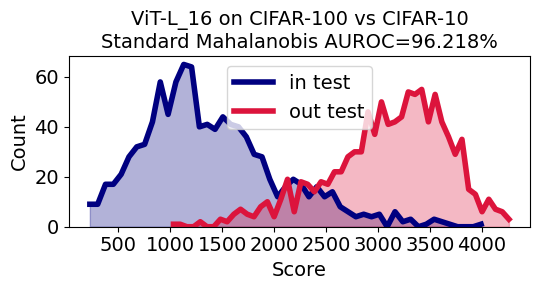

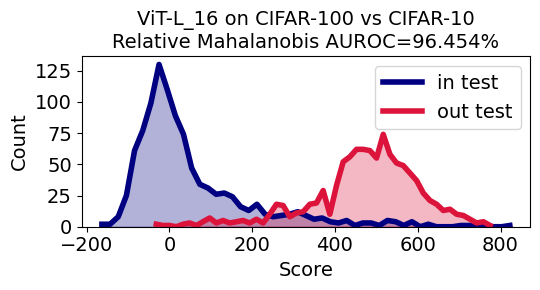

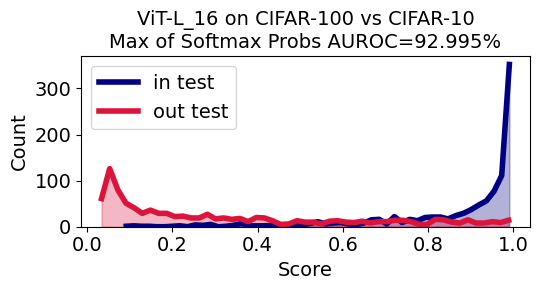

# Imports and loading

In [1]:
import numpy as np

In [2]:
![ -d vision_transformer ] 
!pwd

/content


In [3]:
# Fetch vision_transformer repository.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer

Cloning into 'vision_transformer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 37 (delta 4), reused 31 (delta 4), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [4]:
# Install dependencies.
!pip install -qr vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 65 kB 3.1 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 207 kB 68.7 MB/s 
     |████████████████████████████████| 88 kB 7.9 MB/s 
     |████████████████████████████████| 179.8 MB 60 kB/s 
     |████████████████████████████████| 126 kB 78.9 MB/s 


In [5]:
!ls vision_transformer/vit_jax/

checkpoint.py		__init__.py	   models_resnet.py  train.py
checkpoint_test.py	input_pipeline.py  models_test.py    train_test.py
configs			main.py		   momentum_clip.py  utils.py
inference_time.py	models_mixer.py    requirements.txt
inference_time_test.py	models.py	   test_utils.py


In [6]:
# fetch out repository to get the modified models.py file with the pre-logits extraction
!git clone --depth=1 https://github.com/stanislavfort/https://github.com/stanislavfort/exploring_the_limits_of_OOD_detection

Cloning into 'adversaries_to_OOD_detection'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [7]:
!rm vision_transformer/vit_jax/models.py
!cp exploring_the_limits_of_OOD_detection/models.py vision_transformer/vit_jax/

In [8]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import models
from vit_jax import train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config

In [9]:
#to add the prelogits versions
from google.colab import files

files.view('vision_transformer/vit_jax/models.py')

<IPython.core.display.Javascript object>

In [10]:
!nvidia-smi

Fri Jan 14 17:25:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


# Loading ViT checkpoints from Google Brain repo

### Load a checkpoint

In [12]:
#selecting a ViT checkpoint
filename = 'L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.01-res_384'

tfds_name = filename.split('--')[1].split('-')[0]
model_config = models_config.AUGREG_CONFIGS[filename.split('-')[0]]
resolution = int(filename.split('_')[-1])
path = f'gs://vit_models/augreg/{filename}.npz'

print(f'{tf.io.gfile.stat(path).length / 1024 / 1024:.1f} MiB - {path}')

1159.0 MiB - gs://vit_models/augreg/L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.01-res_384.npz


In [13]:
ds, ds_info = tfds.load(tfds_name, with_info=True,batch_size=128)
ds_info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteY44NQN/cifar100-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteY44NQN/cifar100-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cifar100',
    version=3.0.2,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {

In [14]:
# Get a clean model
model = models.VisionTransformer(
    num_classes=ds_info.features['label'].num_classes, **model_config)

In [15]:
# Load a checkpoint from cloud
# takes a while for a big model
params = checkpoint.load(path)

In [16]:
# out modified model that outputs pre-logits = embeddings for OOD detection
model_prelogits = models.VisionTransformer_prelogits(
    num_classes=ds_info.features['label'].num_classes, **model_config)

# Getting unaugmented datasets

In [17]:
def pp(img, sz):
  img = tf.cast(img, float) / 255.0
  img = tf.image.resize(img, [sz, sz])
  return img

In [18]:
import tensorflow_datasets as tfds 
import tensorflow as tf

def prepare_pure_dataset(ds_in, num_classes,repeats = 1,shuffle=True, batch_size=128):

  ds_in = ds_in.map(lambda d: {"image": pp(d["image"],resolution), "label": d["label"]}, tf.data.experimental.AUTOTUNE)

  ds_in = ds_in.repeat(repeats)
  if shuffle:
    ds_in = ds_in.shuffle(200000)

  ds_in = ds_in.batch(batch_size, drop_remainder=True)

  return ds_in

In [19]:
batch_size = 128

cifar10_ds_train = prepare_pure_dataset(tfds.load('cifar10', split='train', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
cifar10_ds_test = prepare_pure_dataset(tfds.load('cifar10', split='test', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
cifar100_ds_train = prepare_pure_dataset(tfds.load('cifar100', split='train', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)
cifar100_ds_test = prepare_pure_dataset(tfds.load('cifar100', split='test', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete6GRUU0/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete6GRUU0/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [20]:
#verification
def get_value_spreads_for_dataset(ds_in):
  batch = next(ds_in.as_numpy_iterator())
  images = batch["image"]
  min_now,mean_now,max_now = np.min(images),np.mean(images),np.max(images)
  return min_now,mean_now,max_now

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar10_ds_train)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar10_ds_test)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar100_ds_train)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar100_ds_test)
print(min_now,mean_now,max_now)


0.0 0.47670496 1.0
0.0 0.4786665 1.0
0.0 0.5022136 1.0
0.0 0.47278368 1.0


# Prelogits extraction

## Extractor

In [21]:
import time

def standalone_get_prelogits(params, ds_in,image_count=50000):
  """Returns prelogits on the dataset"""
  prelogits_all = []
  logits_all = []
  labels_all = []

  ts = []

  t1 = time.time()

  for batch in ds_in.as_numpy_iterator():

    prelogits = model_prelogits.apply({'params': params}, batch["image"], train=False)
    logits = model.apply({'params': params}, batch["image"], train=False)

    prelogits_all.append(prelogits)
    logits_all.append(logits)
    labels_all.append(batch["label"])

    count_so_far = len(np.concatenate(prelogits_all,axis=0))

    t2 = time.time()
    ts.append(t2-t1)
    t1 = time.time()

    t_rem = (image_count-count_so_far)*np.mean(ts)/batch_size

    print("Images done="+str(count_so_far)+" time remaining="+str(int(t_rem))+"s")

    if count_so_far >= image_count:
      break #early break for subsets of data

  return np.concatenate(prelogits_all,axis=0), np.concatenate(logits_all,axis=0), np.concatenate(labels_all,axis=0)

## Getting the prelogits

The full datasets extraction will take some time. Taking a 1/10 subset is sufficient to show the effectivness of the Mahalanobis distance and Relative Mahalanobis distance as compared to the Maximum over Softmax Probabilities and runs in 20 mins on a single V100 GPU in a Colab (probably slower on a P100).

In [22]:
# choosing the subsets of the train and test set to extract embeddings for
N_train = 5000
N_test = 1000

assert N_train <= 50000
assert N_test <= 10000

### CIFAR-10 test (1.5 minutes)

In [23]:
cifar10_test_prelogits, cifar10_test_logits, cifar10_test_labels = standalone_get_prelogits(
    params, 
    cifar10_ds_test, 
    image_count=N_test
    )

Images done=128 time remaining=194s
Images done=256 time remaining=115s
Images done=384 time remaining=81s
Images done=512 time remaining=59s
Images done=640 time remaining=41s
Images done=768 time remaining=25s
Images done=896 time remaining=11s
Images done=1024 time remaining=-2s


### CIFAR-100 test (1.5 minutes)

In [24]:
cifar100_test_prelogits, cifar100_test_logits, cifar100_test_labels = standalone_get_prelogits(
    params, 
    cifar100_ds_test, 
    image_count=N_test
    )

Images done=128 time remaining=77s
Images done=256 time remaining=65s
Images done=384 time remaining=54s
Images done=512 time remaining=42s
Images done=640 time remaining=31s
Images done=768 time remaining=20s
Images done=896 time remaining=9s
Images done=1024 time remaining=-2s


### CIFAR-10 train (8 minutes)

In [25]:
cifar10_train_prelogits, cifar10_train_logits, cifar10_train_labels = standalone_get_prelogits(
    params, 
    cifar10_ds_train, 
    image_count=N_train
    )

Images done=128 time remaining=436s
Images done=256 time remaining=418s
Images done=384 time remaining=406s
Images done=512 time remaining=393s
Images done=640 time remaining=381s
Images done=768 time remaining=370s
Images done=896 time remaining=358s
Images done=1024 time remaining=347s
Images done=1152 time remaining=335s
Images done=1280 time remaining=324s
Images done=1408 time remaining=313s
Images done=1536 time remaining=302s
Images done=1664 time remaining=291s
Images done=1792 time remaining=279s
Images done=1920 time remaining=268s
Images done=2048 time remaining=257s
Images done=2176 time remaining=246s
Images done=2304 time remaining=235s
Images done=2432 time remaining=224s
Images done=2560 time remaining=212s
Images done=2688 time remaining=201s
Images done=2816 time remaining=190s
Images done=2944 time remaining=179s
Images done=3072 time remaining=168s
Images done=3200 time remaining=156s
Images done=3328 time remaining=145s
Images done=3456 time remaining=134s
Images d

### CIFAR-100 train (8 minutes)

In [26]:
cifar100_train_prelogits, cifar100_train_logits, cifar100_train_labels = standalone_get_prelogits(
    params, 
    cifar100_ds_train, 
    image_count=N_train
    )

Images done=128 time remaining=429s
Images done=256 time remaining=416s
Images done=384 time remaining=403s
Images done=512 time remaining=391s
Images done=640 time remaining=380s
Images done=768 time remaining=368s
Images done=896 time remaining=357s
Images done=1024 time remaining=346s
Images done=1152 time remaining=335s
Images done=1280 time remaining=323s
Images done=1408 time remaining=312s
Images done=1536 time remaining=301s
Images done=1664 time remaining=290s
Images done=1792 time remaining=279s
Images done=1920 time remaining=268s
Images done=2048 time remaining=257s
Images done=2176 time remaining=245s
Images done=2304 time remaining=234s
Images done=2432 time remaining=223s
Images done=2560 time remaining=212s
Images done=2688 time remaining=201s
Images done=2816 time remaining=190s
Images done=2944 time remaining=178s
Images done=3072 time remaining=167s
Images done=3200 time remaining=156s
Images done=3328 time remaining=145s
Images done=3456 time remaining=134s
Images d

## Accuracies

In [27]:
# checking the accuracy on CIFAR-100

finetune_test_acc = np.mean(
    np.argmax(cifar100_test_logits,axis=-1) == cifar100_test_labels
    )

print("CIFAR-100 test accuracy = "+str(finetune_test_acc))

finetune_train_acc = np.mean(
    np.argmax(cifar100_train_logits,axis=-1) == cifar100_train_labels
    )

print("CIFAR-100 train accuracy = "+str(finetune_train_acc))

CIFAR-100 test accuracy = 0.943359375
CIFAR-100 train accuracy = 0.9728515625


# Computing near-OOD AUROC

In [28]:
cifar10_test_embeds = cifar10_test_prelogits
cifar10_y_test = cifar10_test_labels
cifar10_test_preds = cifar10_test_logits

cifar100_test_embeds = cifar100_test_prelogits
cifar100_y_test = cifar100_test_labels
cifar100_test_preds = cifar100_test_logits

cifar10_train_embeds = cifar10_train_prelogits
cifar10_y_train = cifar10_train_labels
cifar10_train_preds = cifar10_train_logits

cifar100_train_embeds = cifar100_train_prelogits
cifar100_y_train = cifar100_train_labels
cifar100_train_preds = cifar100_train_logits

## Computing Mahalanobis means and covariances

In [29]:
def np_softmax(zs):
  exps = np.exp(zs-np.max(zs))
  return exps/np.sum(exps,axis=-1,keepdims=True)

In [30]:
from sklearn.metrics import roc_auc_score

def maha_distance(xs,cov_inv_in,mean_in,norm_type=None):
  diffs = xs - mean_in.reshape([1,-1])

  second_powers = np.matmul(diffs,cov_inv_in)*diffs

  if norm_type in [None,"L2"]:
    return np.sum(second_powers,axis=1)
  elif norm_type in ["L1"]:
    return np.sum(np.sqrt(np.abs(second_powers)),axis=1)
  elif norm_type in ["Linfty"]:
    return np.max(second_powers,axis=1)

def get_scores(
    indist_train_embeds_in,
    indist_train_labels_in,
    indist_test_embeds_in,
    outdist_test_embeds_in,
    subtract_mean = True,
    normalize_to_unity = True,
    subtract_train_distance = True,
    indist_classes = 100,
    norm_name = "L2",
    ):
  
  # storing the replication results
  maha_intermediate_dict = dict()
  
  description = ""
  
  all_train_mean = np.mean(indist_train_embeds_in,axis=0,keepdims=True)

  indist_train_embeds_in_touse = indist_train_embeds_in
  indist_test_embeds_in_touse = indist_test_embeds_in
  outdist_test_embeds_in_touse = outdist_test_embeds_in

  if subtract_mean:
    indist_train_embeds_in_touse -= all_train_mean
    indist_test_embeds_in_touse -= all_train_mean
    outdist_test_embeds_in_touse -= all_train_mean
    description = description+" subtract mean,"

  if normalize_to_unity:
    indist_train_embeds_in_touse = indist_train_embeds_in_touse / np.linalg.norm(indist_train_embeds_in_touse,axis=1,keepdims=True)
    indist_test_embeds_in_touse = indist_test_embeds_in_touse / np.linalg.norm(indist_test_embeds_in_touse,axis=1,keepdims=True)
    outdist_test_embeds_in_touse = outdist_test_embeds_in_touse / np.linalg.norm(outdist_test_embeds_in_touse,axis=1,keepdims=True)
    description = description+" unit norm,"

  #full train single fit
  mean = np.mean(indist_train_embeds_in_touse,axis=0)
  cov = np.cov((indist_train_embeds_in_touse-(mean.reshape([1,-1]))).T)

  eps = 1e-8
  cov_inv = np.linalg.inv(cov)

  #getting per class means and covariances
  class_means = []
  class_cov_invs = []
  class_covs = []
  for c in range(indist_classes):

    mean_now = np.mean(indist_train_embeds_in_touse[indist_train_labels_in == c],axis=0)

    cov_now = np.cov((indist_train_embeds_in_touse[indist_train_labels_in == c]-(mean_now.reshape([1,-1]))).T)
    class_covs.append(cov_now)
    # print(c)

    eps = 1e-8
    cov_inv_now = np.linalg.inv(cov_now)

    class_cov_invs.append(cov_inv_now)
    class_means.append(mean_now)

  #the average covariance for class specific
  class_cov_invs = [np.linalg.inv(np.mean(np.stack(class_covs,axis=0),axis=0))]*len(class_covs)

  maha_intermediate_dict["class_cov_invs"] = class_cov_invs
  maha_intermediate_dict["class_means"] = class_means
  maha_intermediate_dict["cov_inv"] = cov_inv
  maha_intermediate_dict["mean"] = mean

  out_totrain = maha_distance(outdist_test_embeds_in_touse,cov_inv,mean,norm_name)
  in_totrain = maha_distance(indist_test_embeds_in_touse,cov_inv,mean,norm_name)

  out_totrainclasses = [maha_distance(outdist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]
  in_totrainclasses = [maha_distance(indist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]

  out_scores = np.min(np.stack(out_totrainclasses,axis=0),axis=0)
  in_scores = np.min(np.stack(in_totrainclasses,axis=0),axis=0)

  if subtract_train_distance:
    out_scores = out_scores - out_totrain
    in_scores = in_scores - in_totrain


  onehots = np.array([1]*len(out_scores) + [0]*len(in_scores))
  scores = np.concatenate([out_scores,in_scores],axis=0)

  return onehots, scores, description, maha_intermediate_dict

In [31]:
from sklearn.metrics import roc_auc_score

def get_auroc(onehots,scores,make_plot = True,add_to_title=None,swap_classes=False):

  auroc = roc_auc_score(onehots, scores)

  to_replot_dict = dict()

  if swap_classes == False:
    out_scores,in_scores = scores[onehots==0], scores[onehots==1] 
  else:
    out_scores,in_scores = scores[onehots==1], scores[onehots==0] 

  if make_plot:
    plt.figure(figsize = (5.5,3),dpi=100)

    if add_to_title is not None:
      plt.title(add_to_title+" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)
    else:
      plt.title(" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)


  vals,bins = np.histogram(out_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="in test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

  to_replot_dict["out_bin_centers"] = bin_centers
  to_replot_dict["out_vals"] = vals

  vals,bins = np.histogram(in_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="out test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

  to_replot_dict["in_bin_centers"] = bin_centers
  to_replot_dict["in_vals"] = vals

  if make_plot:
    plt.xlabel("Score",fontsize=14)
    plt.ylabel("Count",fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim([0,None])

    plt.legend(fontsize = 14)

    plt.tight_layout()
    plt.show()

  return auroc,to_replot_dict

## Standard Mahalanobis distance

In [32]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
        np.array(cifar100_test_embeds)[:,:],
        np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = False,
    )


In [33]:
class_means = maha_intermediate_dict["class_means"]
class_cov_invs = maha_intermediate_dict["class_cov_invs"]

indist_test_embeds = cifar100_test_embeds

outdist_test_embeds = cifar10_test_embeds

indist_dists = []
for c in range(100):
  indist_offset_now = indist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(indist_offset_now,class_cov_invs[c])*indist_offset_now,axis=1)
  indist_dists.append(maha_dists_now)

outdist_dists = []
for c in range(100):
  outdist_offset_now = outdist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(outdist_offset_now,class_cov_invs[c])*outdist_offset_now,axis=1)
  outdist_dists.append(maha_dists_now)



In [34]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [35]:
print("CIFAR-100 score = "+str(np.mean(indist_min))+"+-"+str(np.std(indist_min)))
print("CIFAR-10 score = "+str(np.mean(outdist_min))+"+-"+str(np.std(outdist_min)))

CIFAR-100 score = 1391.4418850563839+-649.6479017258216
CIFAR-10 score = 3097.3693140415235+-569.8437096871896


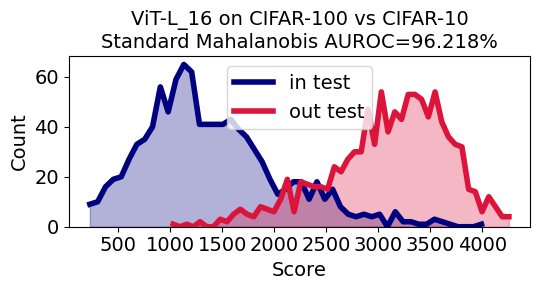

In [36]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nStandard Mahalanobis"
    )

## Relative Mahalanobis distance

In [37]:
train_mean = maha_intermediate_dict["mean"]
train_cov_inv = maha_intermediate_dict["cov_inv"]

In [38]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
        np.array(cifar100_test_embeds)[:,:],
        np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = True,
    )



In [39]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [40]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

prelogits = indist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
indist_train_dist = train_maha_dist

prelogits = outdist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
outdist_train_dist = train_maha_dist

outdist_scores = outdist_min-outdist_train_dist
indist_scores = indist_min-indist_train_dist

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_scores,indist_scores],axis=0)

In [41]:
print("CIFAR-100 score = "+str(np.mean(indist_scores))+"+-"+str(np.std(indist_scores)))
print("CIFAR-10 score = "+str(np.mean(outdist_scores))+"+-"+str(np.std(outdist_scores)))

CIFAR-100 score = 53.70648706882346+-140.7992890457364
CIFAR-10 score = 479.0666854535716+-131.749445282126


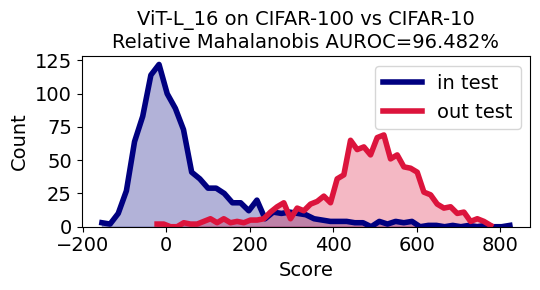

In [42]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nRelative Mahalanobis"
    )

## Max of Softmax Probabilities score

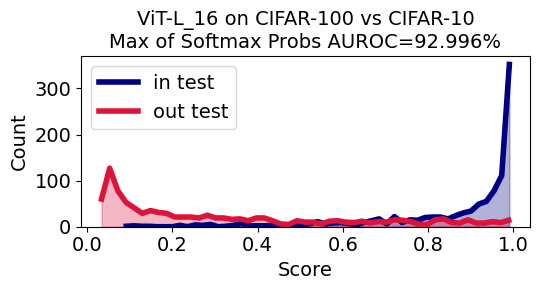

In [43]:
scores = np.array(
    np.concatenate([
     np.max(np_softmax(cifar100_test_logits),axis=-1),
     np.max(np_softmax(cifar10_test_logits),axis=-1),
    ],axis=0)
)

onehots = np.array(
    [1]*len(cifar100_test_logits)+[0]*len(cifar10_test_logits)
)

auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nMax of Softmax Probs",
    swap_classes=True,
    )